# ResNet Model Building Pipeline for 1D Signals with DEMO

# Test GPU (Optional)
Before Starting, kindly check the available GPU from the Google Server, GPU model and other related information. It might help!

In [1]:
import torch
print("Is CUDA enabled GPU Available?", torch.cuda.is_available())
print("GPU Number:", torch.cuda.device_count())
print("Current GPU Index:", torch.cuda.current_device())
print("GPU Type:", torch.cuda.get_device_name(device=None))
print("GPU Capability:", torch.cuda.get_device_capability(device=None))
print("Is GPU Initialized yet?", torch.cuda.is_initialized())

Is CUDA enabled GPU Available? True
GPU Number: 1
Current GPU Index: 0
GPU Type: Tesla P100-PCIE-16GB
GPU Capability: (6, 0)
Is GPU Initialized yet? True


# Connect to Google Drive (Optional for Google COLAB)

In [68]:
from google.colab import drive
drive.mount('/content/GDrive')

Drive already mounted at /content/GDrive; to attempt to forcibly remount, call drive.mount("/content/GDrive", force_remount=True).


Move to the Target Directory

In [225]:
%cd /content

/content


List the Files and Folders Located in the Current Directory

In [226]:
!ls

Drug_Persistency.xlsx  GDrive  sample_data


Upload Files from Local Directory

In [ ]:
from google.colab import files
uploaded = files.upload()

#Import Necessary Libraries

In [204]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, concatenate, BatchNormalization, Activation, add
from keras.layers import Conv2D, MaxPooling2D, Reshape, Flatten, Dense
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Import ResNet1D Module
from ResNet_1DCNN import ResNet

# DEMO: Build and Train ResNet Models for Regression and Classification Tasks


## Regression

### Import and Prepare Dataset for Regression

Import Dataset from a CSV file using Pandas

In [ ]:
dataset = pd.read_csv('Gender_H_W Dataset.csv')
print(dataset.shape)

(10000, 3)


Have a look at the dataset!

In [ ]:
dataset.head(10)

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801
5,Male,67.253016,152.212156
6,Male,68.785081,183.927889
7,Male,68.348516,167.971111
8,Male,67.018950,175.929440
9,Male,63.456494,156.399676


Convert Text Data into Dummy Variables for Machine Learning

In [ ]:
dummy_dataset = pd.DataFrame()

In [ ]:
for i in range(0,len(dataset.columns)):
  X = dataset[dataset.columns[i]]
  if type(X[0]) == str:
    Y = pd.get_dummies(X)
    dummy_dataset = pd.concat([dummy_dataset, Y], axis=1)
  else:
    dummy_dataset = pd.concat([dummy_dataset, X], axis=1)
#
dummy_dataset.shape

(10000, 4)

In [ ]:
dummy_dataset.head(10)

,Female,Male,Height,Weight
0,0,1,73.847017,241.893563
1,0,1,68.781904,162.310473
2,0,1,74.110105,212.740856
3,0,1,71.730978,220.042470
4,0,1,69.881796,206.349801
5,0,1,67.253016,152.212156
6,0,1,68.785081,183.927889
7,0,1,68.348516,167.971111
8,0,1,67.018950,175.929440
9,0,1,63.456494,156.399676


Convert Pandas DataFrame into NumPy Array

In [ ]:
X_Data = dummy_dataset.iloc[:,0:-1].values
Y_Data = dummy_dataset.iloc[:,-1].values
print(X_Data.shape)
print(Y_Data.shape)

(10000, 3)
(10000,)


Train-Test Split

In [ ]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X_Data, Y_Data, test_size=0.20, random_state=42)

In [ ]:
X_Train = X_Train.astype('int')
X_Test = X_Test.astype('int')
Y_Train = Y_Train.astype('int')
Y_Test = Y_Test.astype('int')

In [ ]:
X_Train = np.expand_dims(X_Train, axis=2)

In [ ]:
print(X_Train.shape, X_Test.shape)
print(Y_Train.shape, Y_Test.shape)

(8000, 3, 1) (2000, 3)
(8000,) (2000,)


### Build and Train Imported Data using the ResNet based Regression Model

Configurations

In [ ]:
"Configurations for ResNet in Regression Mode"
length = X_Train.shape[1]   # Number of Features (or length of the signal)
model_width = 64            # Number of Filter or Kernel in the Input Layer
num_channel = 1             # Number of Input Channels
problem_type = 'Regression' # Regression or Classification
feature_number = X_Train.shape[2] # Feature Numbers to be Extracted in Regression Mode

Build Model

In [ ]:
Regression_Model = VGG(length, num_channel, model_width, problem_type=problem_type, output_nums=feature_number).VGG19() # Change the ResNet Model if needed
Regression_Model.compile(loss='mean_absolute_error', optimizer='adam', metrics= ['mean_squared_error'])

Model_Summary

In [ ]:
Regression_Model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 3, 1)]            0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 3, 64)             256       
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 3, 64)             12352     
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 1, 128)            24704     
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 1, 128)            49280     
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 1, 128)            0   

Upload Past Weights (Transfer Learning)

In [ ]:
Regression_Model.load_weights('Saved_Model.h5') # Load Previously Trained Weights for Transfer Learning

Train Model

In [ ]:
# Early Stopping and Model_Checkpoints are optional parameters
# Early Stopping is to stop the training based on certain condition set by the user
# Model Checkpoint is to save a model in a directory based on certain conditions so that it can be used later for Transfer Learning or avoiding retraining
callbacks = [EarlyStopping(monitor='val_loss', patience=30, mode='min'), ModelCheckpoint('Saved_Model.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='min')]
history = Regression_Model.fit(X_Train, Y_Train, epochs=500, batch_size=128, verbose=1, validation_split=0.2, shuffle=True, callbacks=callbacks)

Test

In [ ]:
# Preictions from the Test Set from the Trained Model
Predictions = Regression_Model.predict(X_Test, verbose=1)
print(Predictions.shape)

63/63 [==============================] - 1s 4ms/step
(2000, 1)


Error Performance

In [ ]:
# Error of the prediction, one of many evaluation metrics
# Using Mean Absolute Error (MAE) in this case as a sample
Error = mean_absolute_error(Y_Test, Predictions)
print(f"MAE: {Error}")

MAE: 8.887734546661378


Monitor Train and Validation Error and Loss

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


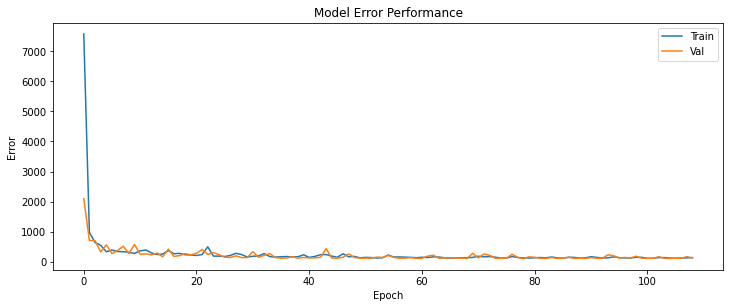

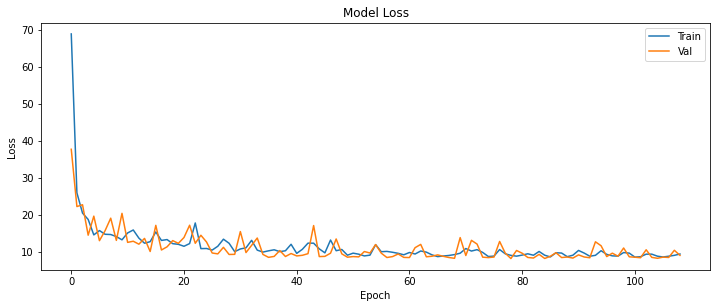

In [ ]:
def history_plot(history):
  # list all dictionaries in history
  print(history.history.keys())
  # summarize history for error
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,1)
  plt.plot(history.history['mean_squared_error'])
  plt.plot(history.history['val_mean_squared_error'])
  plt.title('Model Error Performance')
  plt.ylabel('Error')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
  # summarize history for loss
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
#
history_plot(history)

Plot Prediction Performance

In [ ]:
def plot_prediction(test_labels, test_predictions):
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,1)
  plt.scatter(test_labels, test_predictions)
  plt.title('Ground Truth vs. Prediction Scatter Plot')
  plt.xlabel('Ground Truth')
  plt.ylabel('Predictions')
  plt.axis('equal')
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())
  _ = plt.plot([-100, 100],[-100,100])
  #
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,2)
  plt.title('Error Histogram')
  error = test_predictions - test_labels
  plt.hist(error, bins = 50)
  plt.xlabel("Prediction Error")
  _ = plt.ylabel("Count")

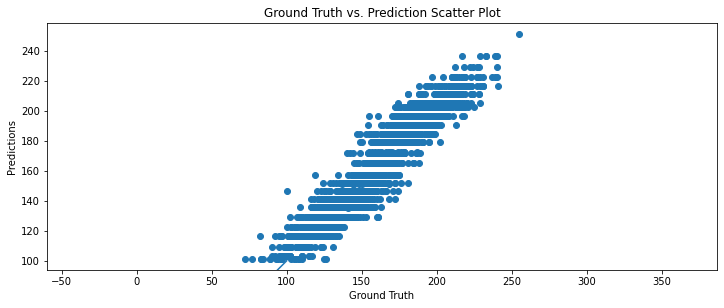

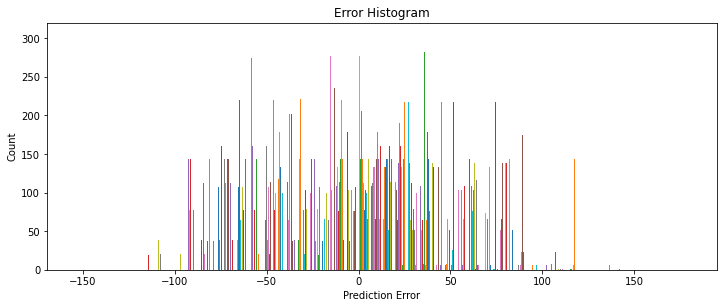

In [ ]:
plot_prediction(Y_Test, Predictions)

## Classification

### Data Preparation

In [170]:
dataset = pd.read_excel('Drug_Persistency.xlsx', sheet_name = 'Dataset')
dataset.drop(columns=['Ptid'], inplace=True)
print(dataset.shape)
dataset.head(10)

(3424, 68)


,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,Gluco_Record_During_Rx,Dexa_Freq_During_Rx,Dexa_During_Rx,Frag_Frac_Prior_Ntm,Frag_Frac_During_Rx,Risk_Segment_Prior_Ntm,Tscore_Bucket_Prior_Ntm,Risk_Segment_During_Rx,Tscore_Bucket_During_Rx,Change_T_Score,Change_Risk_Segment,Adherent_Flag,Idn_Indicator,Injectable_Experience_During_Rx,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",Comorb_Vitamin_D_Deficiency,Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified,Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx,Comorb_Long_Term_Current_Drug_Therapy,Comorb_Dorsalgia,Comorb_Personal_History_Of_Other_Diseases_And_Conditions,Comorb_Other_Disorders_Of_Bone_Density_And_Structure,Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias,Comorb_Osteoporosis_without_current_pathological_fracture,Comorb_Personal_history_of_malignant_neoplasm,Comorb_Gastro_esophageal_reflux_disease,Concom_Cholesterol_And_Triglyceride_Regulating_Preparations,Concom_Narcotics,Concom_Systemic_Corticosteroids_Plain,Concom_Anti_Depressants_And_Mood_Stabilisers,Concom_Fluoroquinolones,Concom_Cephalosporins,Concom_Macrolides_And_Similar_Types,Concom_Broad_Spectrum_Penicillins,Concom_Anaesthetics_General,Concom_Viral_Vaccines,Risk_Type_1_Insulin_Dependent_Diabetes,Risk_Osteogenesis_Imperfecta,Risk_Rheumatoid_Arthritis,Risk_Untreated_Chronic_Hyperthyroidism,Risk_Untreated_Chronic_Hypogonadism,Risk_Untreated_Early_Menopause,Risk_Patient_Parent_Fractured_Their_Hip,Risk_Smoking_Tobacco,Risk_Chronic_Malnutrition_Or_Malabsorption,Risk_Chronic_Liver_Disease,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks
0,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,VLR_LR,<=-2.5,No change,Unknown,Adherent,N,Y,N,Y,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0
1,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0
2,Non-Persistent,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,HR_VHR,<=-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,Y,N,Y,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,Y,N,N,N,N,N,N,N,2
3,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,Y,0,N,N,N,HR_VHR,>-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,N,Y,Y,N,Y,N,N,Y,N,N,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1
4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,Y,Y,0,N,N,N,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,Y,Y,Y,N,N,N,N,Y,Y,N,N,N,N,N,N,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1
5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,Y,N,N,N,N,N,N,N,N,2
6,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,2,Y,N,N,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,N,N,Y,Y,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,Y,N,N,Y,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,1
7,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/

In [171]:
dummy_dataset = pd.DataFrame()

In [172]:
for i in range(0,len(dataset.columns)):
  X = dataset[dataset.columns[i]]
  if type(X[0]) == str:
    Y = pd.get_dummies(X)
    dummy_dataset = pd.concat([dummy_dataset, Y], axis=1)
  else:
    dummy_dataset = pd.concat([dummy_dataset, X], axis=1)
#
dummy_dataset.head(10)

,Non-Persistent,Persistent,Female,Male,African American,Asian,Caucasian,Other/Unknown,Hispanic,Not Hispanic,Unknown,Midwest,Northeast,Other/Unknown,South,West,55-65,65-75,<55,>75,CARDIOLOGY,CLINICAL NURSE SPECIALIST,EMERGENCY MEDICINE,ENDOCRINOLOGY,GASTROENTEROLOGY,GENERAL PRACTITIONER,GERIATRIC MEDICINE,HEMATOLOGY & ONCOLOGY,HOSPICE AND PALLIATIVE MEDICINE,HOSPITAL MEDICINE,NEPHROLOGY,NEUROLOGY,NUCLEAR MEDICINE,OBSTETRICS & OBSTETRICS & GYNECOLOGY & OBSTETRICS & GYNECOLOGY,OBSTETRICS AND GYNECOLOGY,OCCUPATIONAL MEDICINE,ONCOLOGY,OPHTHALMOLOGY,ORTHOPEDIC SURGERY,ORTHOPEDICS,...,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,Count_Of_Risks
0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0
1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0
2,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,2
3,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
4,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
5,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,2
6,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
7,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
8,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
9,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1


Convert to a Numpy Array from Pandas DataFrame

In [195]:
X_Data = dummy_dataset.iloc[:,0:-1].values
Y_Data = dummy_dataset.iloc[:,-1].values
print(X_Data.shape)
print(Y_Data.shape)

(3424, 182)
(3424,)


In [196]:
X_Train = X_Train.astype('float32')
X_Test = X_Test.astype('float32')
Y_Train = Y_Train.astype('int')
Y_Test = Y_Test.astype('int')

In [197]:
X_Train, X_Test, Y_Train_, Y_Test_ = train_test_split(X_Data, Y_Data, test_size=0.20, random_state=42)

One-Hot Encoding for the Labels

In [198]:
def one_hot_encoding(data):
  integer_encoded = LabelEncoder().fit_transform(data)
  onehot_encoder = OneHotEncoder(sparse=False)
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  one_hot_encoded_data = onehot_encoder.fit_transform(integer_encoded)
  return one_hot_encoded_data

In [199]:
Y_Train = one_hot_encoding(Y_Train_)
Y_Test = one_hot_encoding(Y_Test_)

Train and Test Data Shapes

In [200]:
print(X_Train.shape, X_Test.shape)
print(Y_Train.shape, Y_Test.shape)

(2739, 182) (685, 182)
(2739, 8) (685, 8)


### Build and Train Imported Data using the ResNet based Classification Model

Configurations

In [189]:
"Configurations for ResNet in Classification Mode"
length = X_Train.shape[1]       # Number of Features (or length of the signal)
model_width = 64                # Number of Filter or Kernel in the Input Layer
num_channel = 1                 # Number of Input Channels
problem_type = 'Classification' # Regression or Classification
class_number = Y_Train.shape[1] # Number of Output Class in Classification Mode (>=2)

Build Model

In [215]:
Classification_Model = ResNet(length, num_channel, model_width, problem_type=problem_type, output_nums=class_number).ResNet152() # Change the ResNet Model if needed
if class_number == 2:
  Classification_Model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mse'])
elif class_number > 2:
  Classification_Model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['mse'])

Model Summary

In [216]:
Classification_Model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 182, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_396 (Conv1D)             (None, 91, 64)       512         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_2 (MaxPooling1D)  (None, 45, 64)       0           conv1d_396[0][0]                 
__________________________________________________________________________________________________
conv1d_406 (Conv1D)             (None, 45, 64)       4160        max_pooling1d_2[0][0]            
____________________________________________________________________________________________

Upload Past Weights (Transfer Learning)

In [ ]:
Classification_Model.load_weights('Saved_Classification_Model.h5') # Load Previously Trained Weights for Transfer Learning

Train Model

In [ ]:
# Early Stopping and Model_Checkpoints are optional parameters
# Early Stopping is to stop the training based on certain condition set by the user
# Model Checkpoint is to save a model in a directory based on certain conditions so that it can be used later for Transfer Learning or avoiding retraining
callbacks = [EarlyStopping(monitor='val_loss', patience=50, mode='min'), ModelCheckpoint('Saved_Model.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='min')]
history = Classification_Model.fit(X_Train, Y_Train, epochs=300, batch_size=64, verbose=1, validation_split=0.2, shuffle=True, callbacks=callbacks)

Test

In [221]:
# Preictions from the Test Set from the Trained Model
Predictions = Classification_Model.predict(X_Test, verbose=1)
print(Predictions.shape)

22/22 [==============================] - 0s 6ms/step
(685, 8)


Error Performance

In [222]:
# Error of the prediction, one of many evaluation metrics
# Using Mean Absolute Error (MAE) in this case as a sample
Error = mean_absolute_error(Y_Test, Predictions)
print(f"MAE: {Error}")

MAE: 0.06283684200303333


History

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


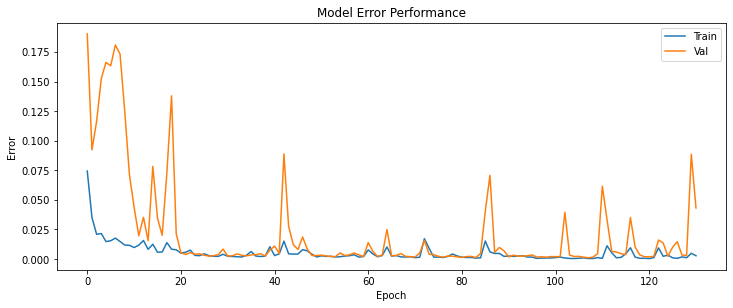

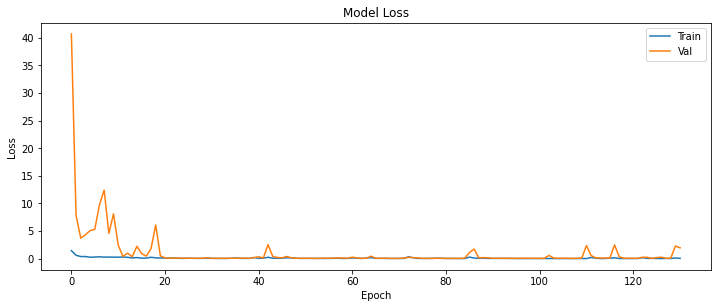

In [218]:
def history_plot(history):
  # list all dictionaries in history
  print(history.history.keys())
  # summarize history for error
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,1)
  plt.plot(history.history['mse'])
  plt.plot(history.history['val_mse'])
  plt.title('Model Error Performance')
  plt.ylabel('Error')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
  # summarize history for loss
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
#
history_plot(history)

Confusion Matrix

In [223]:
prediction_shape = Predictions.shape
prediction_length = prediction_shape[0]
Y_Labels = np.zeros((prediction_length, 1))
#
for i in range(0, prediction_length):
  prediction = Predictions[i]
  x = np.where(prediction == np.max(prediction))
  x = x[0]
  x = x.astype('int')
  Y_Labels[i] = x

Y_Labels.shape

(685, 1)

Text(0.5, 1.0, 'Confusion Matrix')

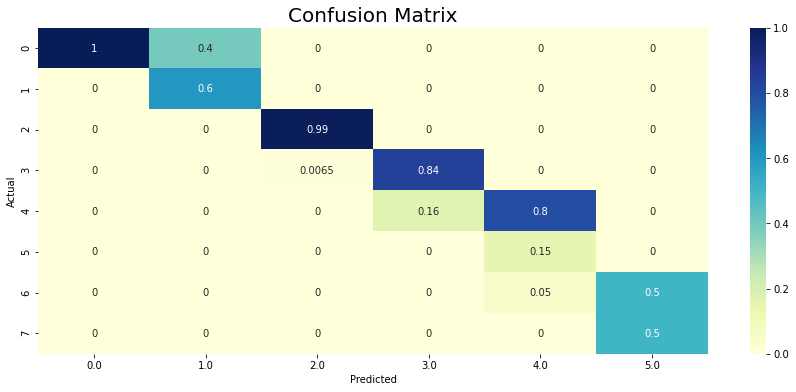

In [224]:
Conf = {'y_Actual': Y_Test_.ravel(), 'y_Predicted': Y_Labels.ravel()}
Conf = pd.DataFrame(data=Conf)
df_Conf_Mat = pd.DataFrame(Conf, columns=['y_Actual', 'y_Predicted'])
confusion_matrix = pd.crosstab(df_Conf_Mat['y_Actual'], df_Conf_Mat['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], normalize='columns')
plt.figure(figsize=(15, 6))
sns.heatmap(confusion_matrix, cmap='YlGnBu', annot=True)
plt.title('Confusion Matrix', fontsize=20)